In [191]:
import re
import pandas as pd
import numpy as np
import glob
import os
import shutil
import fnmatch
import itertools
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import cm
from scipy.optimize import curve_fit, minimize
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

In [192]:
# Edit the major and minor ticks of the x and y axes
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 3
mpl.rcParams['xtick.major.width'] = mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.direction'] = mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.top'] = mpl.rcParams['ytick.major.right'] = True
mpl.rcParams['xtick.minor.size'] = mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = mpl.rcParams['axes.labelsize'] =  mpl.rcParams['legend.fontsize'] = 14


# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = "Arial"
mpl.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = "bold"
plt.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = [3.2, 3.2]

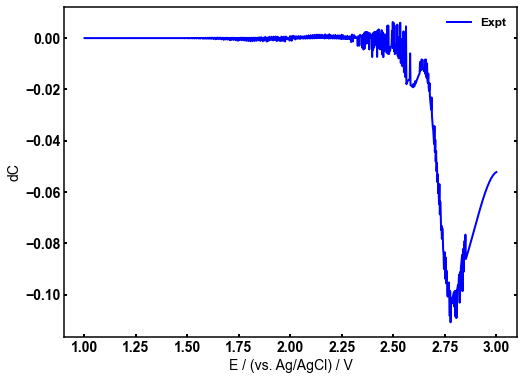

In [97]:
# helper functions
R = 8.314
T = 298
F = 96485

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return idx

def cross(x, y):
    """
    To make all the curves meet at zero at 
    occupancy 0.5
    """
    idx = find_nearest(x, 0.5)
    y0 = y[idx]
    return y - y0



def smooth_data(x, y):
    xx = np.linspace(x.min(),x.max(), 1000)

    # interpolate + smooth
    itp = interp1d(x,y, kind='linear')
    window_size, poly_order = 151, 4 # 121, 4 is optimal
    yy_sg = savgol_filter(itp(xx), window_size, poly_order)
    return (xx, yy_sg)



def get_mole_fraction_matrix(Q, E):
    Q1 = Q.copy()
    x_min = np.min(Q1)
    x_max = np.max(Q1)
    charge = ((Q1 - x_min) / (x_max - x_min))[1:-1] # charge
    mole_fraction = charge
    potential = E[1:-1]
    return(np.column_stack([mole_fraction, potential]))


def smooth(x, box_pts):
    box = np.ones(box_pts)/ box_pts
    print(len(x))
    x_smooth = np.convolve(box, x, mode='same') 
    return x_smooth

def get_dqdv_matrix_from_file(Q_fpath):
    R = 8.314
    T = 298.15
    F = 96485
    Q_df = pd.read_csv(Q_fpath, sep = '\t',header = 1, names = ['Q', 'V'])
    V_smooth, Q_smooth = smooth_data(Q_df.V.values, Q_df.Q.values)
    dQdV = np.diff(Q_smooth) / np.diff(V_smooth)
    dC = (1/np.max(np.abs(Q_df.Q.values)) * ((R*T)/F) *  dQdV) # Normalization
    V = V_smooth[1:].copy() 
    return((np.column_stack([V, dC])))
  

def get_dqdv_matrix_from_array(voltage, charge):
    R = 8.314
    T = 298.15
    F = 96485
    V_smooth, Q_smooth = smooth_data(voltage, charge)
    dQdV = np.diff(Q_smooth) / np.diff(V_smooth)
    dC = (1/np.max(np.abs(charge)) * ((R*T)/F)*dQdV)
    V = V_smooth[1:].copy() 
    return(np.column_stack([V, dC]))
 

def get_charge_and_voltage_matrix(Q_fpath):
    Q_df = pd.read_csv(Q_fpath, sep = '\t',header = 1, names = ['Q', 'V'])
    return(np.column_stack([Q_df.V.values, Q_df.Q.values]))


def FWHM(x,y):
    half_max = max(y) / 2.
    #find when function crosses line half_max (when sign of diff flips)
    #take the 'derivative' of signum(half_max - Y[])
    d = np.sign(half_max - np.array(y[0:-1])) - np.sign(half_max - np.array(y[1:]))
    #plt.plot(X[0:len(d)],d) #if you are interested
    #find the left and right most indexes
    left_idx = np.where(d > 0)[0]
    right_idx = np.where(d < 0)[-1]
    return x[right_idx] - x[left_idx] #return the difference (full width)



def peak_finder(x0, y0, window_size, peak_threshold):
    # extend x, y using window size
    y = np.concatenate([y0, np.repeat(y0[-1], window_size)])
    x = np.concatenate([x0, np.arange(x0[-1], x0[-1]+window_size)])
    local_max = np.zeros(len(x0))
    for ii in range(len(x0)):
        local_max[ii] = x[y[ii:(ii + window_size)].argmax() + ii]

    u, c = np.unique(local_max, return_counts=True)
    i_return = np.where(c>=peak_threshold)[0]
    return(list(zip(u[i_return], c[i_return])))


E = get_dqdv_matrix_from_array(V, q)[:,0]
dC = get_dqdv_matrix_from_array(V, q)[:,1]
fig = plt.figure(figsize=(7.5, 5.5))
ax = fig.add_subplot(111)

ax.plot(E, -dC, \
        linestyle = "-", linewidth=2, color = "blue")
#ax.set_title("Cycle" + "=" )
ax.set_ylabel('dC')
ax.set_xlabel('E / (vs. Ag/AgCl) / V')
ax.legend(['Expt', 'Fit'], loc=1, frameon=False, fontsize=12) # Enlarge to a region

fig.tight_layout()

In [134]:
V = np.load('C:/Users/John/Documents/Python/john_battery/data/V_LTP_CC.npy')[496:763]/1000 + 0.788
print(V.shape)


(267,)


In [136]:
dt = 10
icc = 72 # mA/g (constant current value)
I = icc * np.ones(V.size)  # mA/g (current array)
q = np.cumsum(I) * (dt/3600) # in mAh/g (instantanous capacity array)
soc = (q/max(q))*100 # (state of charge)


#Voltage and current extracted with DMFA from 2 cycles:

voltage = np.load('C:/Users/John/Documents/Python/john_battery/data/V_LTP_CC.npy')/1000 + 0.788 # V vs SHE

I = np.load('C:/Users/John/Documents/Python/john_battery/data/I_LTP_CC.npy')

time = 10* np.arange(1000)

 

#Impedance of one cycle (charge-discahrge):

Z = np.load('C:/Users/John/Documents/Python/john_battery/data/Z_LTP_CC.npy')[:,496:989]

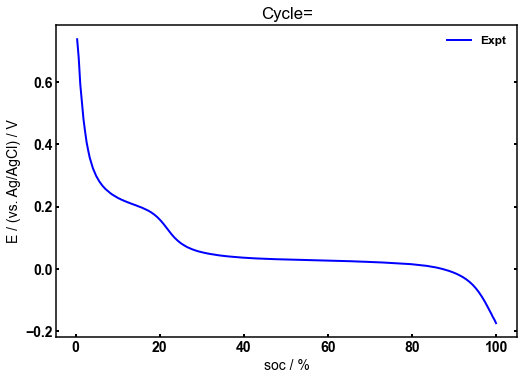

In [7]:
fig = plt.figure(figsize=(7.5, 5.5))
ax = fig.add_subplot(111)

ax.plot(soc, V, \
        linestyle = "-", linewidth=2, color = "blue")
ax.set_title("Cycle" + "=" )
ax.set_ylabel('E / (vs. Ag/AgCl) / V')
ax.set_xlabel(r'soc / %')
ax.legend(['Expt', 'Fit'], loc=1, frameon=False, fontsize=12) # Enlarge to a region

fig.tight_layout()


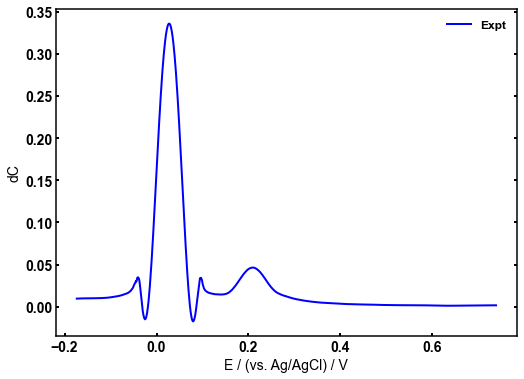

In [137]:
E = get_dqdv_matrix_from_array(V, q)[:,0]
dC = get_dqdv_matrix_from_array(V, q)[:,1]
fig = plt.figure(figsize=(7.5, 5.5))
ax = fig.add_subplot(111)

ax.plot(E, -dC, \
        linestyle = "-", linewidth=2, color = "blue")
#ax.set_title("Cycle" + "=" )
ax.set_ylabel('dC')
ax.set_xlabel('E / (vs. Ag/AgCl) / V')
ax.legend(['Expt', 'Fit'], loc=1, frameon=False, fontsize=12) # Enlarge to a region

fig.tight_layout()


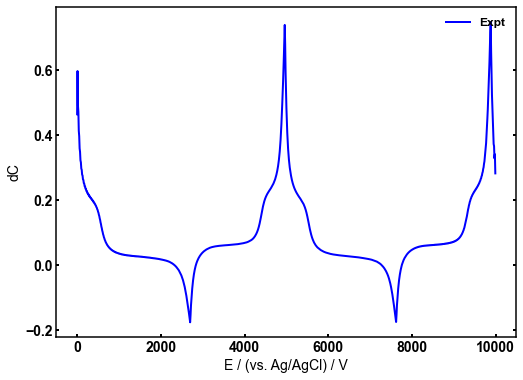

In [25]:
fig = plt.figure(figsize=(7.5, 5.5))
ax = fig.add_subplot(111)

ax.plot(time[:], voltage, \
        linestyle = "-", linewidth=2, color = "blue")
#ax.set_title("Cycle" + "=" )
ax.set_ylabel('dC')
ax.set_xlabel('E / (vs. Ag/AgCl) / V')
ax.legend(['Expt', 'Fit'], loc=1, frameon=False, fontsize=12) # Enlarge to a region

fig.tight_layout()

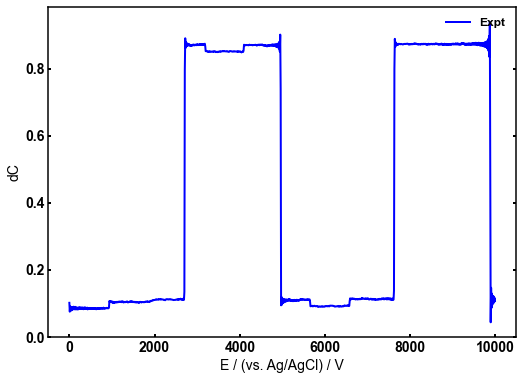

In [26]:
fig = plt.figure(figsize=(7.5, 5.5))
ax = fig.add_subplot(111)

ax.plot(time[:], current, \
        linestyle = "-", linewidth=2, color = "blue")
#ax.set_title("Cycle" + "=" )
ax.set_ylabel('dC')
ax.set_xlabel('E / (vs. Ag/AgCl) / V')
ax.legend(['Expt', 'Fit'], loc=1, frameon=False, fontsize=12) # Enlarge to a region

fig.tight_layout()

In [ ]:
#cyling data

In [168]:
import pandas as pd

# Specify the path to your file
file_path = 'C:/Users/John/Documents/Python/john_battery/Battery_cycling/MnO2_coin cell_cycling_C01.txt'

# Define the column names based on the given headers


columns = ["cycle number","Q discharge/mA.h","Q charge/mA.h","Ewe/V","(Q-Qo)/mA.h", "time/s", "<I>/mA"]

# Read the data, specifying the delimiter as a tab
data = pd.read_csv(file_path, sep='\t', skiprows=1, header=None, names=columns, engine='python')

# Convert the comma to a dot if the numbers are in the European format
data = data.applymap(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

# Filter the data for cycles 1 to 10
filtered_data = data[(data['cycle number'] >= 0) & (data['cycle number'] <= 10)]

# Filter the data for cycle 1
cycle_1_data = filtered_data[filtered_data['cycle number'] ==1 ]
cycle_1_data 
# Print the data for cycle 1
#print(data['cycle number'].unique())

,cycle number,Q discharge/mA.h,Q charge/mA.h,Ewe/V,(Q-Qo)/mA.h,time/s,<I>/mA
1221,1.0,0.000000,2.331105e-07,1.550475,-43.038476,36109.859756,4.195990
1222,1.0,0.000000,4.804000e-07,1.558672,-43.038475,36109.859956,4.451210
1223,1.0,0.000000,3.730560e-06,1.568989,-43.038472,36109.862556,4.500221
1224,1.0,0.000000,1.373390e-05,1.578999,-43.038462,36109.870556,4.501501
1225,1.0,0.000000,3.048989e-05,1.589005,-43.038445,36109.883956,4.501611
...,...,...,...,...,...,...,...
3221,1.0,37.054561,0.000000e+00,1.000051,-45.181591,93989.993480,-4.497424
3222,1.0,37.054561,0.000000e+00,1.079811,-45.181591,93990.041880,0.000000
3223,1.0,37.054561,0.000000e+00,1.366008,-45.181591,94110.042051,0.000000
3224,1.0,37.054561,0.000000e+00,1.424025,-45.181591,94230.042223,0.000000


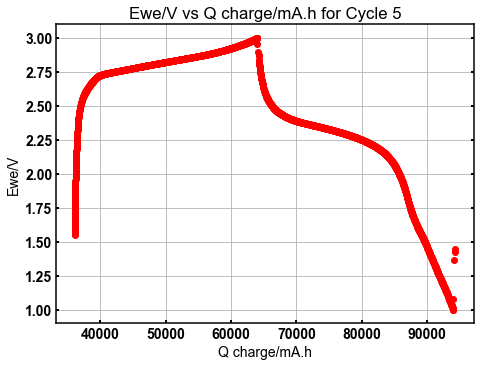

In [169]:
import pandas as pd
import matplotlib.pyplot as plt

# Specify the path to your file
file_path = 'C:/Users/John/Documents/Python/john_battery/Battery_cycling/MnO2_coin cell_cycling_C01.txt'

# Define the column names based on the given headers
columns = ["cycle number","Q discharge/mA.h","Q charge/mA.h","Ewe/V","(Q-Qo)/mA.h", "time/s", "<I>/mA"]

# Read the data, specifying the delimiter as a tab
data = pd.read_csv(file_path, sep='\t', skiprows=1, header=None, names=columns, engine='python')

# Convert the comma to a dot if the numbers are in the European format
data = data.applymap(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

# Filter the data for cycle 5
cycle_1_data = data[data['cycle number'] == 1]
#cycle_5_data = data[data['cycle number'] == 5]
#cycle_9_data = data[data['cycle number'] == 9]

#cycle_1_data = cycle_1_data.to_numpy() 
#cycle_5_data = cycle_5_data.to_numpy() 


fig = plt.figure(figsize=(7.5, 5.5))
ax = fig.add_subplot(111)
# Plot "Ewe/V" vs "Q charge/mA.h" for cycle 5
plt.plot(cycle_1_data['time/s'].to_numpy(),cycle_1_data['Ewe/V'].to_numpy(),'ro')

#plt.plot(cycle_1_data['time/s'], cycle_1_data['Ewe/V'],'b*')



plt.xlabel('Q charge/mA.h')
plt.ylabel('Ewe/V')
plt.title('Ewe/V vs Q charge/mA.h for Cycle 5')
plt.grid(True)
plt.show()


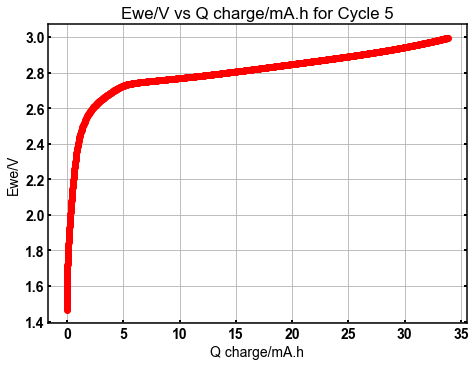

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Specify the path to your file
file_path = 'C:/Users/John/Documents/Python/john_battery/Battery_cycling/MnO2_coin cell_cycling_C01.txt'

# Define the column names based on the given headers
columns = ["cycle number","Q discharge/mA.h","Q charge/mA.h","Ewe/V","(Q-Qo)/mA.h", "time/s", "<I>/mA"]

# Read the data, specifying the delimiter as a tab
data = pd.read_csv(file_path, sep='\t', skiprows=1, header=None, names=columns, engine='python')

# Convert the comma to a dot if the numbers are in the European format
data = data.applymap(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

# Filter the data for cycle 5
cycle_5_data = data[data['cycle number'] ==3]

# Convert selected columns to NumPy arrays
Q_charge = cycle_5_data['Q charge/mA.h'].to_numpy()[:-945]
Ewe_V = cycle_5_data['Ewe/V'].to_numpy()[:-945]

fig = plt.figure(figsize=(7.5, 5.5))
ax = fig.add_subplot(111)

# Plot "Ewe/V" vs "Q charge/mA.h" for cycle 5
plt.plot(Q_charge, Ewe_V, 'ro')

plt.xlabel('Q charge/mA.h')
plt.ylabel('Ewe/V')
plt.title('Ewe/V vs Q charge/mA.h for Cycle 5')
plt.grid(True)
plt.show()


In [104]:
q = cycle_5_data['Q charge/mA.h'].to_numpy()[:-945]
V= cycle_5_data['Ewe/V'].to_numpy()[:-945]

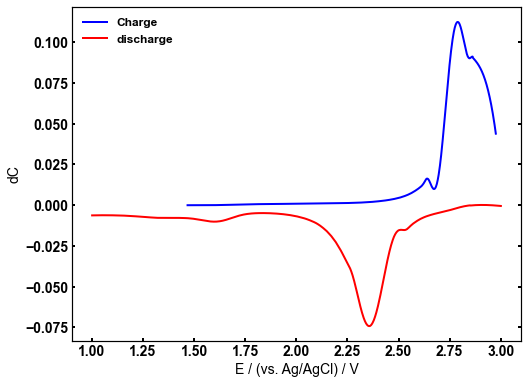

In [193]:
# helper functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Specify the path to your file
file_path = 'C:/Users/John/Documents/Python/john_battery/Battery_cycling/MnO2_coin cell_cycling_C01.txt'

# Define the column names based on the given headers
columns = ["cycle number","Q discharge/mA.h","Q charge/mA.h","Ewe/V","(Q-Qo)/mA.h", "time/s", "<I>/mA"]

# Read the data, specifying the delimiter as a tab
data = pd.read_csv(file_path, sep='\t', skiprows=1, header=None, names=columns, engine='python')

# Convert the comma to a dot if the numbers are in the European format
data = data.applymap(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

# Filter the data for cycle 5
cycle_5_data = data[data['cycle number'] ==3]

# Convert selected columns to NumPy arrays
Q_charge = cycle_5_data['Q charge/mA.h'].to_numpy()[:-945]
Ewe_V = cycle_5_data['Ewe/V'].to_numpy()[:-945]







R = 8.314
T = 298
F = 96485

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return idx

def cross(x, y):
    """
    To make all the curves meet at zero at 
    occupancy 0.5
    """
    idx = find_nearest(x, 0.5)
    y0 = y[idx]
    return y - y0



def smooth_data(x, y):
    xx = np.linspace(x.min(),x.max(), 1000)

    # interpolate + smooth
    itp = interp1d(x,y, kind='linear')
    window_size, poly_order = 151, 4 # 121, 4 is optimal
    yy_sg = savgol_filter(itp(xx), window_size, poly_order)
    return (xx, yy_sg)



def get_mole_fraction_matrix(Q, E):
    Q1 = Q.copy()
    x_min = np.min(Q1)
    x_max = np.max(Q1)
    charge = ((Q1 - x_min) / (x_max - x_min))[1:-1] # charge
    mole_fraction = charge
    potential = E[1:-1]
    return(np.column_stack([mole_fraction, potential]))


def smooth(x, box_pts):
    box = np.ones(box_pts)/ box_pts
    print(len(x))
    x_smooth = np.convolve(box, x, mode='same') 
    return x_smooth

def get_dqdv_matrix_from_file(Q_fpath):
    R = 8.314
    T = 298.15
    F = 96485
    Q_df = pd.read_csv(Q_fpath, sep = '\t',header = 1, names = ['Q', 'V'])
    V_smooth, Q_smooth = smooth_data(Q_df.V.values, Q_df.Q.values)
    dQdV = np.diff(Q_smooth) / np.diff(V_smooth)
    dC = (1/np.max(np.abs(Q_df.Q.values)) * ((R*T)/F) *  dQdV) # Normalization
    V = V_smooth[1:].copy() 
    return((np.column_stack([V, dC])))
  

def get_dqdv_matrix_from_array(voltage, charge):
    R = 8.314
    T = 298.15
    F = 96485
    V_smooth, Q_smooth = smooth_data(voltage, charge)
    dQdV = np.diff(Q_smooth) / np.diff(V_smooth)
    dC = (1/np.max(np.abs(charge)) * ((R*T)/F)*dQdV)
    V = V_smooth[1:].copy() 
    return(np.column_stack([V, dC]))
 

def get_charge_and_voltage_matrix(Q_fpath):
    Q_df = pd.read_csv(Q_fpath, sep = '\t',header = 1, names = ['Q', 'V'])
    return(np.column_stack([Q_df.V.values, Q_df.Q.values]))


def FWHM(x,y):
    half_max = max(y) / 2.
    #find when function crosses line half_max (when sign of diff flips)
    #take the 'derivative' of signum(half_max - Y[])
    d = np.sign(half_max - np.array(y[0:-1])) - np.sign(half_max - np.array(y[1:]))
    #plt.plot(X[0:len(d)],d) #if you are interested
    #find the left and right most indexes
    left_idx = np.where(d > 0)[0]
    right_idx = np.where(d < 0)[-1]
    return x[right_idx] - x[left_idx] #return the difference (full width)



def peak_finder(x0, y0, window_size, peak_threshold):
    # extend x, y using window size
    y = np.concatenate([y0, np.repeat(y0[-1], window_size)])
    x = np.concatenate([x0, np.arange(x0[-1], x0[-1]+window_size)])
    local_max = np.zeros(len(x0))
    for ii in range(len(x0)):
        local_max[ii] = x[y[ii:(ii + window_size)].argmax() + ii]

    u, c = np.unique(local_max, return_counts=True)
    i_return = np.where(c>=peak_threshold)[0]
    return(list(zip(u[i_return], c[i_return])))

q = cycle_5_data['Q charge/mA.h'].to_numpy()[:-980]
V= cycle_5_data['Ewe/V'].to_numpy()[:-980]
q1 = cycle_5_data['Q discharge/mA.h'].to_numpy()[500:-5]
V1= cycle_5_data['Ewe/V'].to_numpy()[500:-5]

E = get_dqdv_matrix_from_array(V, q)[:,0]
dC = get_dqdv_matrix_from_array(V, q)[:,1]
E1 = get_dqdv_matrix_from_array(V1, q1)[:,0]
dC1 = get_dqdv_matrix_from_array(V1, q1)[:,1]
fig = plt.figure(figsize=(7.5, 5.5))
ax = fig.add_subplot(111)

ax.plot(E, dC, \
        linestyle = "-", linewidth=2, color = "blue")
ax.plot(E1, dC1, \
        linestyle = "-", linewidth=2, color = "red")
#ax.set_title("Cycle" + "=" )
ax.set_ylabel('dC')
ax.set_xlabel('E / (vs. Ag/AgCl) / V')
ax.legend(['Charge', 'discharge'], loc=2, frameon=False, fontsize=12) # Enlarge to a region

fig.tight_layout()

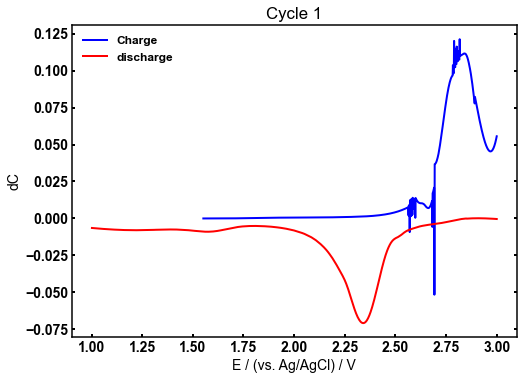

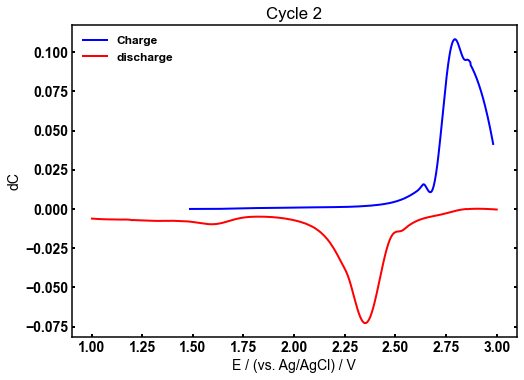

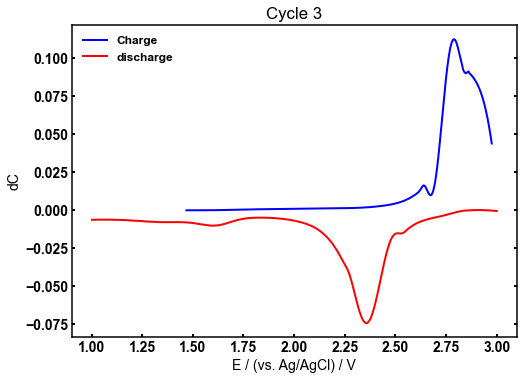

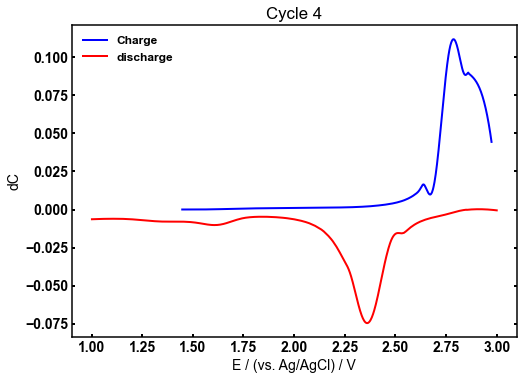

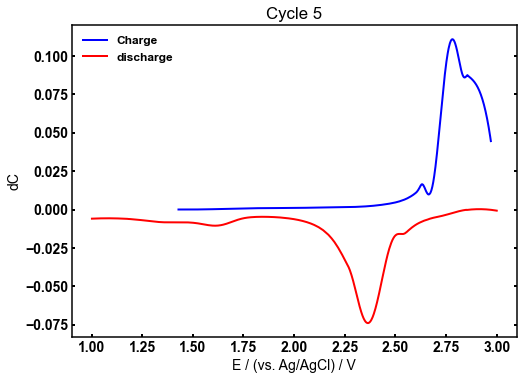

In [142]:
# ... [All imports and definitions remain unchanged]

def plot_cycle(cycle_number):
    cycle_data = data[data['cycle number'] == cycle_number]
    q = cycle_data['Q charge/mA.h'].to_numpy()[:-980]
    V = cycle_data['Ewe/V'].to_numpy()[:-980]
    q1 = cycle_data['Q discharge/mA.h'].to_numpy()[500:-5]
    V1 = cycle_data['Ewe/V'].to_numpy()[500:-5]

    E = get_dqdv_matrix_from_array(V, q)[:, 0]
    dC = get_dqdv_matrix_from_array(V, q)[:, 1]
    E1 = get_dqdv_matrix_from_array(V1, q1)[:, 0]
    dC1 = get_dqdv_matrix_from_array(V1, q1)[:, 1]
    fig = plt.figure(figsize=(7.5, 5.5))
    ax = fig.add_subplot(111)

    ax.plot(E, dC, linestyle="-", linewidth=2, color="blue")
    ax.plot(E1, dC1, linestyle="-", linewidth=2, color="red")
    ax.set_title(f"Cycle {cycle_number}")
    ax.set_ylabel('dC')
    ax.set_xlabel('E / (vs. Ag/AgCl) / V')
    ax.legend(['Charge', 'discharge'], loc=2, frameon=False, fontsize=12)

    fig.tight_layout()
    plt.show()

# Plot cycles 1 to 5 (for example)
for i in range(1, 6):
    plot_cycle(i)


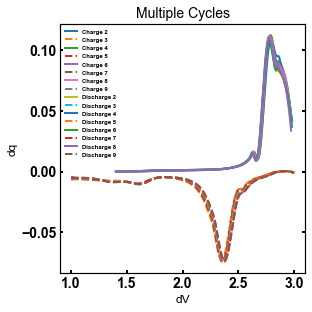

In [197]:
# ... [All imports and definitions remain unchanged]

def get_cycle_data(cycle_number):
    cycle_data = data[data['cycle number'] == cycle_number]
    q = cycle_data['Q charge/mA.h'].to_numpy()[:-980]
    V = cycle_data['Ewe/V'].to_numpy()[:-980]
    q1 = cycle_data['Q discharge/mA.h'].to_numpy()[500:-5]
    V1 = cycle_data['Ewe/V'].to_numpy()[500:-5]

    E = get_dqdv_matrix_from_array(V, q)[:, 0]
    dC = get_dqdv_matrix_from_array(V, q)[:, 1]
    E1 = get_dqdv_matrix_from_array(V1, q1)[:, 0]
    dC1 = get_dqdv_matrix_from_array(V1, q1)[:, 1]

    return E, dC, E1, dC1

fig = plt.figure(figsize=(4.5, 4.5))
ax = fig.add_subplot(111)

# Add multiple cycles to the same plot
selected_cycles = [2, 3, 4, 5,6,7,8,9]  # You can adjust this list to your needs
for i in selected_cycles:
    E, dC, E1, dC1 = get_cycle_data(i)
    ax.plot(E, dC, linestyle="-", linewidth=2)
    ax.plot(E1, dC1, linestyle="--", linewidth=2)

ax.set_title("Multiple Cycles", fontsize=14)
ax.set_ylabel('dq', fontsize=12)
ax.set_xlabel('dV', fontsize=12)
ax.legend([f"Charge {i}" for i in selected_cycles] + [f"Discharge {i}" for i in selected_cycles], loc=2, frameon=False, fontsize=6)
plt.grid(False)
fig.tight_layout()

fig.savefig("C:/Users/John/Desktop/cycling/dqdv.png", format="png", dpi=1000, bbox_inches='tight')
plt.show()

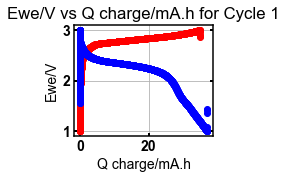

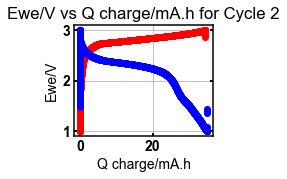

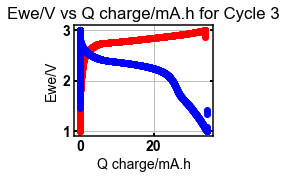

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Specify the path to your file
file_path = 'C:/Users/John/Documents/Python/john_battery/Battery_cycling/MnO2_coin cell_cycling_C01.txt'

# Define the column names based on the given headers
columns = ["cycle number","Q discharge/mA.h","Q charge/mA.h","Ewe/V","(Q-Qo)/mA.h", "time/s", "<I>/mA"]

# Read the data, specifying the delimiter as a tab
data = pd.read_csv(file_path, sep='\t', skiprows=1, header=None, names=columns, engine='python')

# Convert the comma to a dot if the numbers are in the European format
data = data.applymap(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

# List of cycle numbers to plot
cycles_to_plot = [1,2,3]

for cycle_number in cycles_to_plot:
    # Filter the data for the given cycle number
    cycle_data = data[data['cycle number'] == cycle_number]

    # Convert selected columns to NumPy arrays
    Q_charge = cycle_data['Q charge/mA.h'].to_numpy()
    Q_discharge = cycle_data['Q discharge/mA.h'].to_numpy()
    Ewe_V = cycle_data['Ewe/V'].to_numpy()

    fig = plt.figure(figsize=(5.5, 4.5))
    ax = fig.add_subplot(222)

    # Plot "Ewe/V" vs "Q charge/mA.h" for the given cycle
    plt.plot(Q_charge, Ewe_V, 'ro')
    plt.plot(Q_discharge, Ewe_V, 'bo')
    plt.xlabel('Q charge/mA.h')
    plt.ylabel('Ewe/V')
    plt.title(f'Ewe/V vs Q charge/mA.h for Cycle {cycle_number}') # Title includes the current cycle number
    plt.grid(True)
    plt.show()


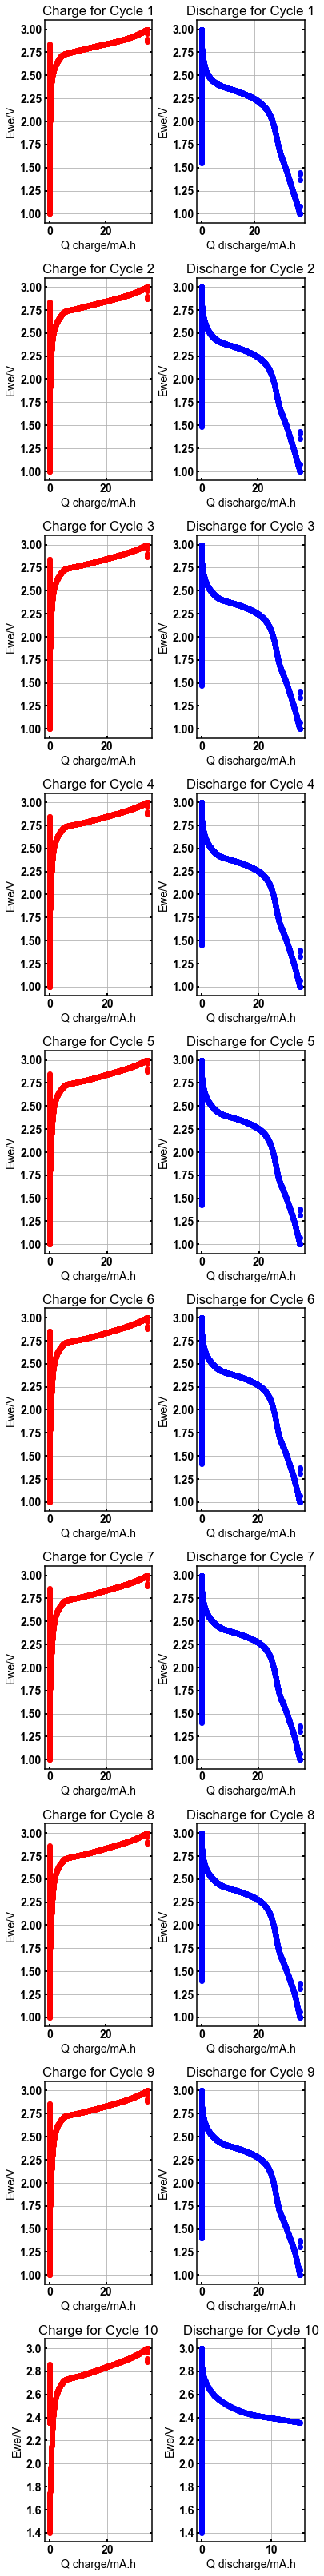

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Specify the path to your file
file_path = 'C:/Users/John/Documents/Python/john_battery/Battery_cycling/MnO2_coin cell_cycling_C01.txt'

# Define the column names based on the given headers
columns = ["cycle number","Q discharge/mA.h","Q charge/mA.h","Ewe/V","(Q-Qo)/mA.h", "time/s", "<I>/mA"]

# Read the data, specifying the delimiter as a tab
data = pd.read_csv(file_path, sep='\t', skiprows=1, header=None, names=columns, engine='python')

# Convert the comma to a dot if the numbers are in the European format
data = data.applymap(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

# List of cycle numbers to plot
cycles_to_plot = [1,2,3,4,5,6,7,8,9,10]

# Number of rows and columns for the subplots
num_rows = len(cycles_to_plot)
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5.5, 4.5 * num_rows))

for index, cycle_number in enumerate(cycles_to_plot):
    # Filter the data for the given cycle number
    cycle_data = data[data['cycle number'] == cycle_number]

    # Convert selected columns to NumPy arrays
    Q_charge = cycle_data['Q charge/mA.h'].to_numpy()
    Q_discharge = cycle_data['Q discharge/mA.h'].to_numpy()
    Ewe_V = cycle_data['Ewe/V'].to_numpy()

    # Plot charge data in the first column
    axes[index, 0].plot(Q_charge, Ewe_V, 'ro')
    axes[index, 0].set_xlabel('Q charge/mA.h')
    axes[index, 0].set_ylabel('Ewe/V')
    axes[index, 0].set_title(f'Charge for Cycle {cycle_number}')
    axes[index, 0].grid(True)

    # Plot discharge data in the second column
    axes[index, 1].plot(Q_discharge, Ewe_V, 'bo')
    axes[index, 1].set_xlabel('Q discharge/mA.h')
    axes[index, 1].set_ylabel('Ewe/V')
    axes[index, 1].set_title(f'Discharge for Cycle {cycle_number}')
    axes[index, 1].grid(True)

plt.tight_layout()
plt.show()


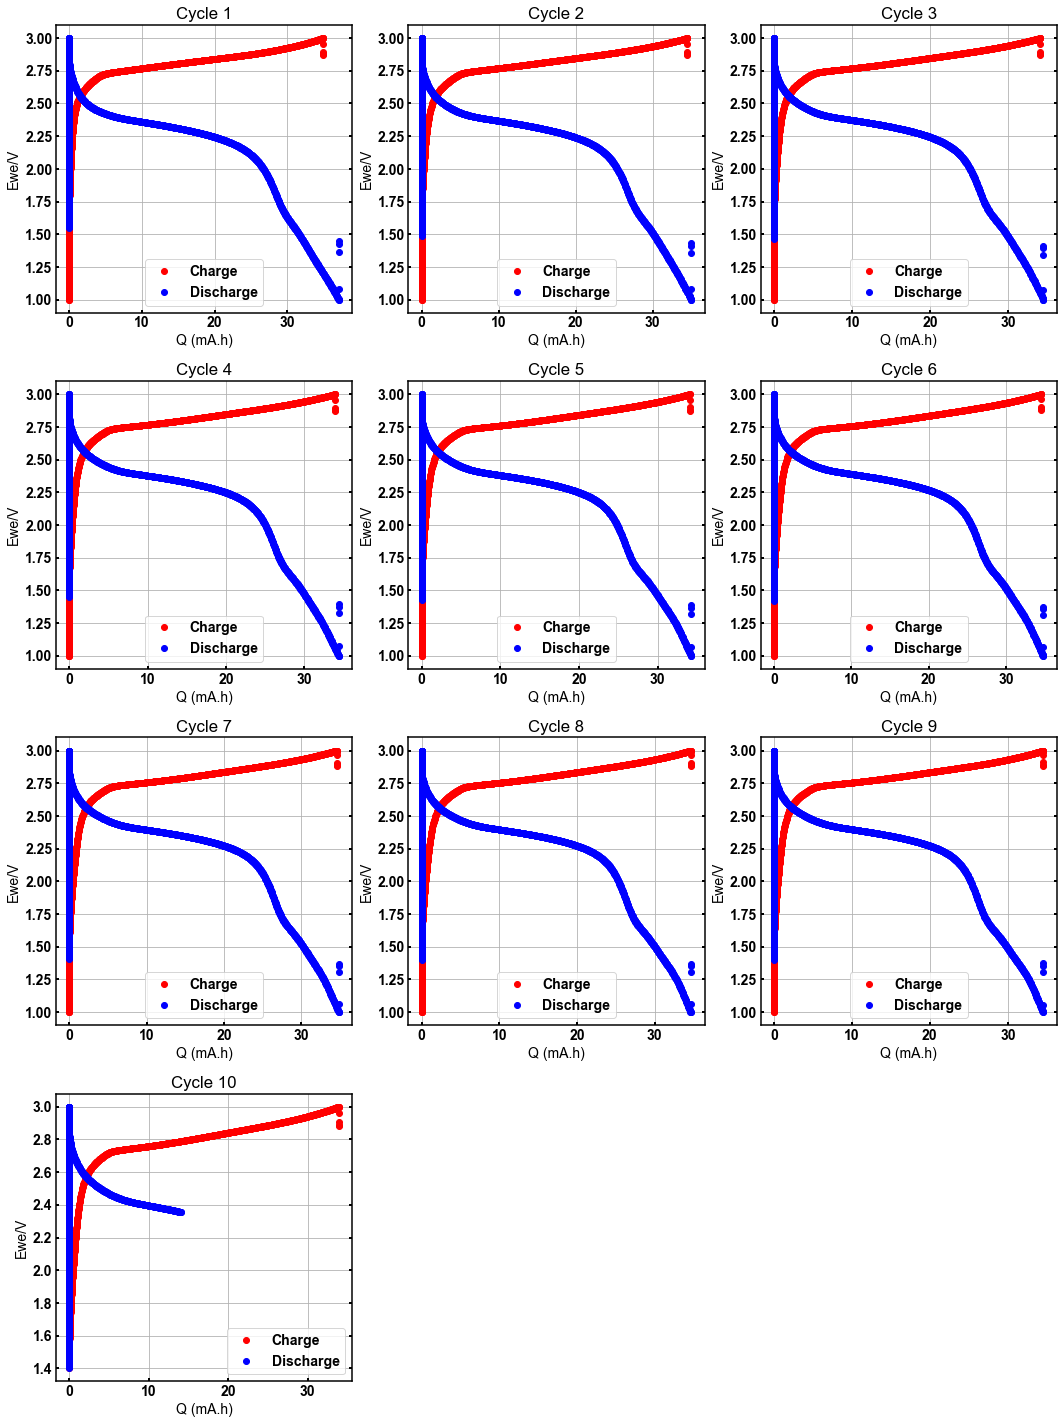

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Specify the path to your file
file_path = 'C:/Users/John/Documents/Python/john_battery/Battery_cycling/MnO2_coin cell_cycling_C01.txt'

# Define the column names based on the given headers
columns = ["cycle number","Q discharge/mA.h","Q charge/mA.h","Ewe/V","(Q-Qo)/mA.h", "time/s", "<I>/mA"]

# Read the data, specifying the delimiter as a tab
data = pd.read_csv(file_path, sep='\t', skiprows=1, header=None, names=columns, engine='python')

# Convert the comma to a dot if the numbers are in the European format
data = data.applymap(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

# List of cycle numbers to plot
cycles_to_plot = [1,2,3,4,5,6,7,8,9,10]

# Calculate the number of rows for the subplots
num_rows = int(np.ceil(len(cycles_to_plot) / 3))
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array to make it one-dimensional
axes = axes.flatten()

for index, cycle_number in enumerate(cycles_to_plot):
    # Filter the data for the given cycle number
    cycle_data = data[data['cycle number'] == cycle_number]

    # Convert selected columns to NumPy arrays
    Q_charge = cycle_data['Q charge/mA.h'].to_numpy()
    Q_discharge = cycle_data['Q discharge/mA.h'].to_numpy()
    Ewe_V = cycle_data['Ewe/V'].to_numpy()

    # Plot charge and discharge data in the same plot
    axes[index].plot(Q_charge, Ewe_V, 'ro', label='Charge')
    axes[index].plot(Q_discharge, Ewe_V, 'bo', label='Discharge')
    axes[index].set_xlabel('Q (mA.h)')
    axes[index].set_ylabel('Ewe/V')
    axes[index].set_title(f'Cycle {cycle_number}')
    axes[index].legend()
    axes[index].grid(True)

# Remove any remaining empty subplots
for i in range(len(cycles_to_plot), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


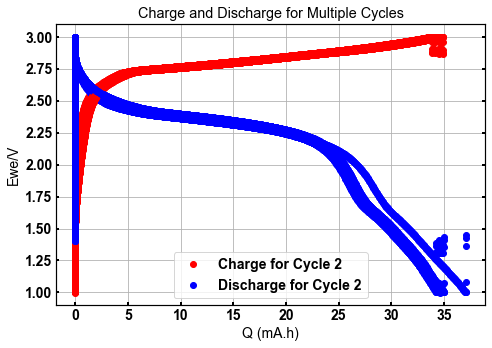

In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Specify the path to your file
file_path = 'C:/Users/John/Documents/Python/john_battery/Battery_cycling/MnO2_coin cell_cycling_C02.txt'

# Define the column names based on the given headers
columns = ["cycle number","Q discharge/mA.h","Q charge/mA.h","Ewe/V","(Q-Qo)/mA.h", "time/s", "<I>/mA","Capacity/mA.h","Efficiency/%" ]

# Read the data, specifying the delimiter as a tab
data = pd.read_csv(file_path, sep='\t', skiprows=1, header=None, names=columns, engine='python')

# Convert the comma to a dot if the numbers are in the European format
data = data.applymap(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

# List of cycle numbers to plot
cycles_to_plot = [1,2,3,4,5,6,7,8,9,10]

fig, ax = plt.subplots(figsize=(7, 5))

for cycle_number in cycles_to_plot:
    # Filter the data for the given cycle number
    cycle_data = data[data['cycle number'] == cycle_number]

    # Convert selected columns to NumPy arrays
    Q_charge = cycle_data['Q charge/mA.h'].to_numpy()
    Q_discharge = cycle_data['Q discharge/mA.h'].to_numpy()
    Ewe_V = cycle_data['Ewe/V'].to_numpy()

    # Plot charge data
    ax.plot(Q_charge, Ewe_V, 'ro', label=f'Charge for Cycle {cycle_number}' if cycle_number == cycles_to_plot[1] else "")
    
    # Plot discharge data
    ax.plot(Q_discharge, Ewe_V, 'bo', label=f'Discharge for Cycle {cycle_number}' if cycle_number == cycles_to_plot[1] else "")

ax.set_xlabel('Q (mA.h)')
ax.set_ylabel('Ewe/V')
ax.set_title('Charge and Discharge for Multiple Cycles')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


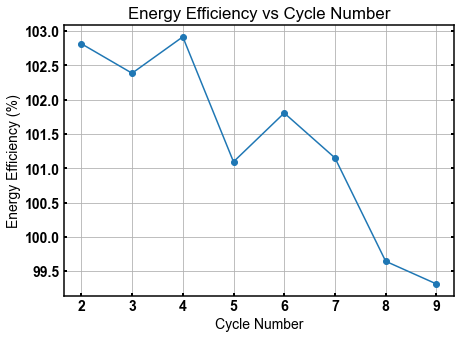

In [66]:
def plot_energy_efficiency_vs_cycle(data, exclude_cycles=None):
    # If no cycles are specified to be excluded, initialize an empty list
    if exclude_cycles is None:
        exclude_cycles = []

    # Extract unique cycles from the data
    unique_cycles = np.unique(data['cycle number'].values)
    efficiencies = []
    cycles_to_plot = []  # List to store cycles that are not excluded

    for cycle in unique_cycles:
        if cycle in exclude_cycles:
            continue
        
        # Create a mask to filter out rows related to the current cycle
        mask = data['cycle number'].values == cycle
        
        # Compute total charge and discharge for the current cycle
        Q_discharge = data['Q discharge/mA.h'].values[mask].sum()
        Q_charge = data['Q charge/mA.h'].values[mask].sum()
        
        # Calculate efficiency for the current cycle
        efficiency = (Q_discharge / Q_charge) * 100
        
        # Append calculated efficiency to the efficiencies list
        efficiencies.append(efficiency)
        
        # Add the current cycle to cycles_to_plot list
        cycles_to_plot.append(cycle)
        
    # Plotting the results
    plt.figure(figsize=(7, 5))
    plt.plot(cycles_to_plot, efficiencies, '-o')  # Use cycles_to_plot instead of unique_cycles
    plt.xlabel('Cycle Number')
    plt.ylabel('Energy Efficiency (%)')
    plt.title('Energy Efficiency vs Cycle Number')
    plt.grid(True)
    plt.show()

# Example usage
exclude = [0,1,10]  # This will exclude the data for cycles 2, 5, and 7
plot_energy_efficiency_vs_cycle(data, exclude_cycles=exclude)


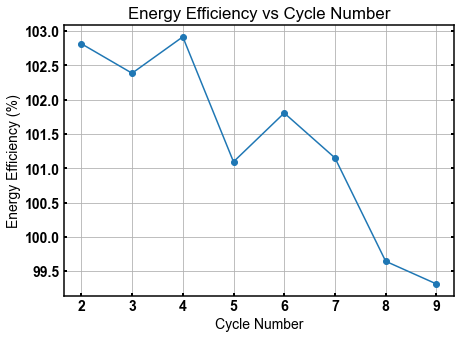

In [68]:
def plot_energy_efficiency_vs_cycle(data, exclude_cycles=None):
    if exclude_cycles is None:
        exclude_cycles = []

    unique_cycles = np.unique(data['cycle number'].values)
    efficiencies = []
    cycles_to_plot = [] # List to store cycles that are not excluded

    for cycle in unique_cycles:
        if cycle in exclude_cycles:
            continue
        
        mask = data['cycle number'].values == cycle
        Q_discharge = data['Q discharge/mA.h'].values[mask].sum()
        Q_charge = data['Q charge/mA.h'].values[mask].sum()
        efficiency = (Q_discharge / Q_charge) * 100
        
        efficiencies.append(efficiency)
        cycles_to_plot.append(cycle) # Add the cycle to this list

    plt.figure(figsize=(7, 5))
    plt.plot(cycles_to_plot, efficiencies, '-o')
    plt.xlabel('Cycle Number')
    plt.ylabel('Energy Efficiency (%)')
    plt.title('Energy Efficiency vs Cycle Number')
    plt.grid(True)
    plt.show()

# Example usage
exclude = [0,1,10]  # This will exclude the data for cycles 2, 5, and 7
plot_energy_efficiency_vs_cycle(data, exclude_cycles=exclude)


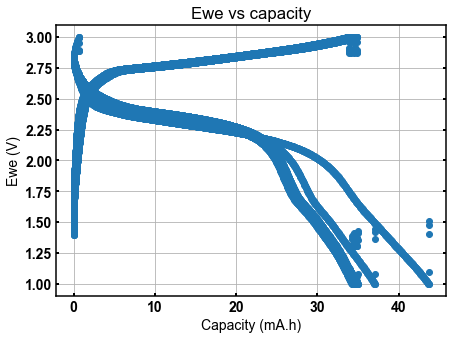

In [140]:
def plot_Ewe_vs_capacity(data):
    Ewe= data['Ewe/V'].values
    capacity = data['Capacity/mA.h'].values

    plt.figure(figsize=(7, 5))
    plt.plot(capacity,Ewe,'o')
    plt.xlabel('Capacity (mA.h)')
    plt.ylabel('Ewe (V)')
    plt.title('Ewe vs capacity')
    plt.grid(True)
    plt.show()

plot_Ewe_vs_capacity(data)


In [ ]:
def plot_capacity_vs_time(data):
    time = data['time/s'].values
    capacity = data['Capacity/mA.h'].values

    plt.figure(figsize=(7, 5))
    plt.plot(time/3600, capacity,'o')
    plt.xlabel('Time (s)')
    plt.ylabel('Capacity (mA.h)')
    plt.title('Capacity vs Time')
    plt.grid(True)
    plt.show()

plot_capacity_vs_time(data)

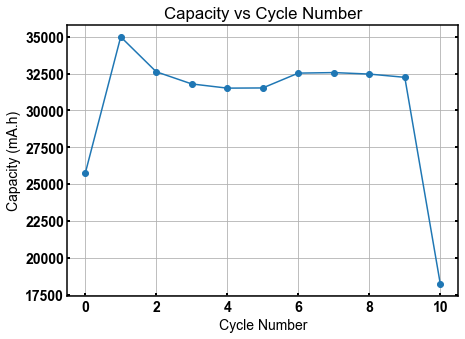

In [69]:
def plot_capacity_vs_cycle(data):
    unique_cycles = np.unique(data['cycle number'].values)
    capacities = []

    for cycle in unique_cycles:
        mask = data['cycle number'].values == cycle
        capacity = data['Capacity/mA.h'].values[mask].sum()
        capacities.append(capacity)

    plt.figure(figsize=(7, 5))
    plt.plot(unique_cycles, capacities, '-o')
    plt.xlabel('Cycle Number')
    plt.ylabel('Capacity (mA.h)')
    plt.title('Capacity vs Cycle Number')
    plt.grid(True)
    plt.show()

plot_capacity_vs_cycle(data)


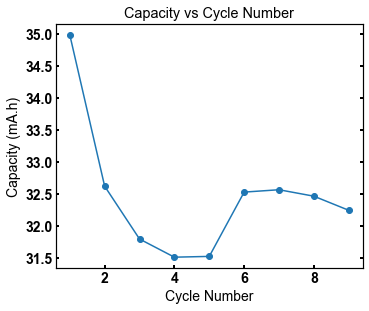

In [236]:


def plot_capacity_vs_cycle(data, exclude_cycles=None):
    # If no cycles are specified to be excluded, initialize an empty list
    if exclude_cycles is None:
        exclude_cycles = []

    # Extract unique cycles from the data
    unique_cycles = np.unique(data['cycle number'].values)
    capacities = []
    cycles_to_plot = []  # List to store cycles that are not excluded
    
    
    for cycle in unique_cycles:
        # Skip the current cycle if it's in the exclude_cycles list
        if cycle in exclude_cycles:
            continue
        
        # Create a mask to filter out rows related to the current cycle
        mask = data['cycle number'].values == cycle
        
        # Compute total capacity for the current cycle
        capacity = data['Capacity/mA.h'].values[mask].sum()/1000
        
        # Append calculated capacity to the capacities list
        capacities.append(capacity)
        
        # Add the current cycle to cycles_to_plot list
        cycles_to_plot.append(cycle)

        
        #fig, ax = plt.subplots(figsize=(6.5, 4.5))
    #fig = plt.subplots(figsize=(6.5, 4.5)) 
    plt.figure(figsize=(5.5, 4.5))
    plt.plot(cycles_to_plot, capacities, '-o')  # Use cycles_to_plot instead of unique_cycles
    plt.xlabel('Cycle Number')
    plt.ylabel('Capacity (mA.h)')
    plt.title('Capacity vs Cycle Number')
    plt.grid(False)
    plt.show()
    fig.savefig("C:/Users/John/Desktop/cycling/capacity_cycle.png", format="png", dpi=1000, bbox_inches='tight')
           
#fig.savefig("C:/Users/John/Desktop/cycling/capacity_cycle.png", format="png", dpi=1000, bbox_inches='tight')
# Example usage
exclude = [0,10]  # This will exclude the data for cycles 2, 5, and 7
plot_capacity_vs_cycle(data, exclude_cycles=exclude)
plt.show()


In [ ]:
# Plotting the results
    #fig, ax = plt.subplots(figsize=(6.5, 4.5)) 
    plt.figure(figsize=(5.5, 4.5))
    plt.plot(cycles_to_plot, capacities, '-o')  # Use cycles_to_plot instead of unique_cycles
    plt.xlabel('Cycle Number')
    plt.ylabel('Capacity (mA.h)')
    plt.title('Capacity vs Cycle Number')
    plt.grid(False)
    plt.show()
    fig.savefig("C:/Users/John/Desktop/cycling/capacity_cycle.png", format="png", dpi=1000, bbox_inches='tight')

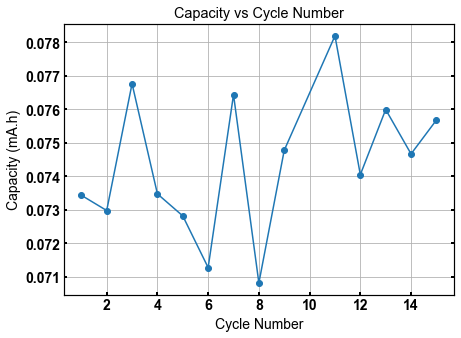

In [216]:
def plot_capacity_vs_cycle(data, exclude_cycles=None):
    # If no cycles are specified to be excluded, initialize an empty list
    if exclude_cycles is None:
        exclude_cycles = []

    # Extract unique cycles from the data
    unique_cycles = np.unique(data['cycle number'].values)
    capacities = []
    cycles_to_plot = []  # List to store cycles that are not excluded

    for cycle in unique_cycles:
        # Skip the current cycle if it's in the exclude_cycles list
        if cycle in exclude_cycles:
            continue
        
        # Create a mask to filter out rows related to the current cycle
        mask = data['cycle number'].values == cycle
        
        # Compute total capacity for the current cycle
        capacity = data['Capacity/mA.h'].values[mask].sum()/1000
        
        # Append calculated capacity to the capacities list
        capacities.append(capacity)
        
        # Add the current cycle to cycles_to_plot list
        cycles_to_plot.append(cycle)
        
    # Plotting the results
    plt.figure(figsize=(7, 5))
    plt.plot(cycles_to_plot, capacities, '-o')  # Use cycles_to_plot instead of unique_cycles
    plt.xlabel('Cycle Number')
    plt.ylabel('Capacity (mA.h)')
    plt.title('Capacity vs Cycle Number')
    plt.grid(True)
    plt.show()

# Example usage
exclude = [0,10]  # This will exclude the data for cycles 2, 5, and 7
plot_capacity_vs_cycle(data, exclude_cycles=exclude)


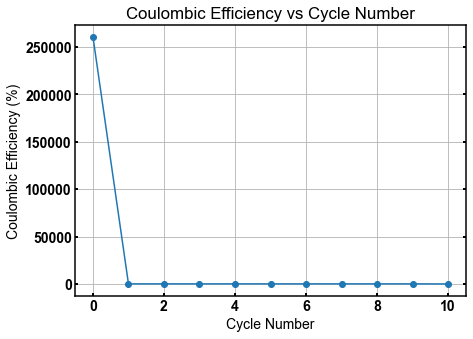

In [180]:
def plot_coulombic_efficiency_vs_cycle(data):
    unique_cycles = np.unique(data['cycle number'].values)
    coulombic_efficiencies = []

    for cycle in unique_cycles:
        mask = data['cycle number'].values == cycle
        Q_discharge = data['Q discharge/mA.h'].values[mask].sum()
        Q_charge = data['Q charge/mA.h'].values[mask].sum()
        efficiency = (Q_discharge / Q_charge) * 100
        coulombic_efficiencies.append(efficiency)

    plt.figure(figsize=(7, 5))
    plt.plot(unique_cycles, coulombic_efficiencies, '-o')
    plt.xlabel('Cycle Number')
    plt.ylabel('Coulombic Efficiency (%)')
    plt.title('Coulombic Efficiency vs Cycle Number')
    plt.grid(True)
    plt.show()

plot_coulombic_efficiency_vs_cycle(data)


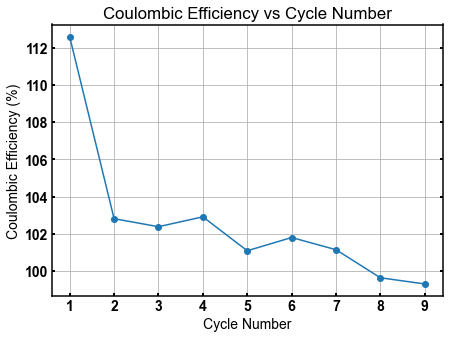

In [118]:
def plot_coulombic_efficiency_vs_cycle(data, excluded_cycles=[]):
    unique_cycles = np.unique(data['cycle number'].values)
    
    # Exclude specific cycles from the list
    unique_cycles = [cycle for cycle in unique_cycles if cycle not in excluded_cycles]

    coulombic_efficiencies = []

    for cycle in unique_cycles:
        mask = data['cycle number'].values == cycle
        Q_discharge = data['Q discharge/mA.h'].values[mask].sum()
        Q_charge = data['Q charge/mA.h'].values[mask].sum()
        efficiency = (Q_discharge / Q_charge) * 100
        coulombic_efficiencies.append(efficiency)

    plt.figure(figsize=(7, 5))
    plt.plot(unique_cycles, coulombic_efficiencies, '-o')
    plt.xlabel('Cycle Number')
    plt.ylabel('Coulombic Efficiency (%)')
    plt.title('Coulombic Efficiency vs Cycle Number')
    plt.grid(True)
    plt.show()

# List of cycles to be excluded from the plot
excluded = [0,10]
plot_coulombic_efficiency_vs_cycle(data, excluded_cycles=excluded)


In [135]:
def plot_differential_capacity(data, exclude_cycles=None):
    if exclude_cycles is None:
        exclude_cycles = []

    unique_cycles = np.unique(data['cycle number'].values)
    # Filter out cycles to exclude
    cycles_to_plot = [cycle for cycle in unique_cycles if cycle not in exclude_cycles]

    plt.figure(figsize=(7, 5))
    
    for cycle in cycles_to_plot:
        # Filter data for specific cycle number
        cycle_data = data[data['cycle number'] == 1]
        
        voltage = cycle_data['Ewe/V'].values[:-945]
        dQ = np.diff(cycle_data['Q charge/mA.h'].values[:-945])
        dV = np.diff(cycle_data['Ewe/V'].values)
        dQdV = dQ/dV

        # Plot the differential capacity for each cycle with a unique label
        plt.plot(voltage, dQdV, label=f'Cycle {cycle}')
    
    plt.xlabel('Voltage (V)')
    plt.ylabel('Differential Capacity (mA.h/V)')
    plt.title('Differential Capacity vs Voltage')
    plt.legend()  # Show the legend to differentiate cycles
    plt.grid(True)
    plt.show()

# Example usage:
exclude = [2, 5, 7]  # This will exclude the data for cycles 2, 5, and 7
plot_differential_capacity(data, exclude_cycles=exclude)


ValueError: operands could not be broadcast together with shapes (1059,) (2004,) 

<Figure size 504x360 with 0 Axes>

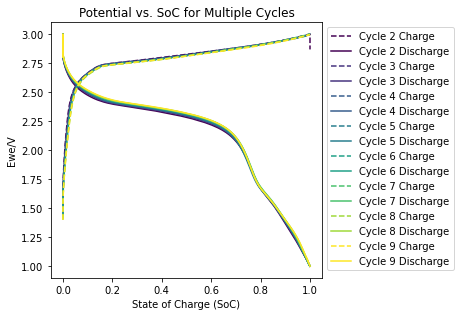

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Q Specify the path to your file
file_path = '/home/mugisa/Documents/battery_app/data/MnO2_coin cell_cycling_C02.txt'

# Define the column names based on the given headers
columns = ["cycle number","Q discharge/mA.h","Q charge/mA.h","Ewe/V","(-Qo)/mA.h", "time/s", "<I>/mA","Capacity/mA.h","Efficiency/%"]

# Read the data, specifying the delimiter as a tab
data = pd.read_csv(file_path, sep='\t', skiprows=1, header=None, names=columns, engine='python')

# Convert the comma to a dot if the numbers are in the European format
data = data.applymap(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

# List of cycle numbers to plot
cycles_to_plot = [2,3,4,5,6,7,8,9]

# Define a colormap to get different colors for each cycle
colors = plt.cm.viridis(np.linspace(0, 1, len(cycles_to_plot)))

fig, ax = plt.subplots(figsize=(6.5, 4.5))

for index, cycle_number in enumerate(cycles_to_plot):
    # Filter the data for the given cycle number
    cycle_data = data[data['cycle number'] == cycle_number]
    
    # Calculate SoC for charge
    max_charge = np.max(cycle_data['Q charge/mA.h'].values[:-945])
    SoC_charge = cycle_data['Q charge/mA.h'].values[:-945] / max_charge
    
    # Calculate SoC for discharge
    max_discharge = np.max(cycle_data['Q discharge/mA.h'].values[500:-5])
    SoC_discharge = cycle_data['Q discharge/mA.h'].values[500:-5] / max_discharge

    Ewe_V_charge = cycle_data['Ewe/V'].to_numpy()[:-945]
    Ewe_V_discharge = cycle_data['Ewe/V'].to_numpy()[500:-5]

    # Plot SoC vs potential, using the colors from the colormap
    ax.plot(SoC_charge, Ewe_V_charge, color=colors[index], linestyle='--', label=f'Cycle {cycle_number} Charge')
    ax.plot(SoC_discharge, Ewe_V_discharge, color=colors[index], linestyle='-', label=f'Cycle {cycle_number} Discharge')

ax.set_xlabel('State of Charge (SoC)')
ax.set_ylabel('Ewe/V')
ax.set_title('Potential vs. SoC for Multiple Cycles')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize=10)  # Move the legend outside
ax.grid(False)
plt.tight_layout()
plt.show()
# fig.savefig("C:/Users/John/Desktop/cycling/v_soc.png", format="png", dpi=1000, bbox_inches='tight')

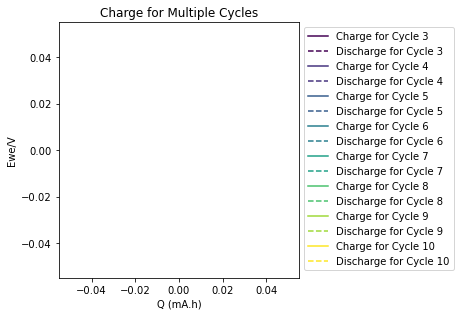

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cmath

# Specify the path to your file
file_path = '/home/mugisa/Documents/battery_app/data/MnO2_coin cell_cycling_C02.txt'

# Define the column names based on the given headers
columns = ["cycle number","Q discharge/mA.h","Q charge/mA.h","Ewe/V","(Q-Qo)/mA.h", "time/s", "<I>/mA"]

# Read the data, specifying the delimiter as a tab
data = pd.read_csv(file_path, sep='\t', skiprows=1, header=None, names=columns, engine='python')

# Convert the comma to a dot if the numbers are in the European format
data = data.applymap(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

# List of cycle numbers to plot
cycles_to_plot = [3,4,5,6,7,8,9,10]

# Define a colormap to get different colors for each cycle
colors = plt.cm.viridis(np.linspace(0, 1, len(cycles_to_plot)))

fig, ax = plt.subplots(figsize=(6.5, 4.5))

for index, cycle_number in enumerate(cycles_to_plot):
    # Filter the data for the given cycle number
    cycle_data = data[data['cycle number'] == cycle_number]

    Q_charge = cycle_data['Q charge/mA.h'].to_numpy()[:-945]
    Ewe_V = cycle_data['Ewe/V'].to_numpy()[:-945]
    Q_discharge = cycle_data['Q discharge/mA.h'].to_numpy()[500:-5]
    Ewe_V1 = cycle_data['Ewe/V'].to_numpy()[500:-5]


    # Plot charge and discharge data, using the colors from the colormap
    ax.plot(Q_charge, Ewe_V, color=colors[index], label=f'Charge for Cycle {cycle_number}')
    ax.plot(Q_discharge, Ewe_V1, color=colors[index], linestyle='dashed', label=f'Discharge for Cycle {cycle_number}')

ax.set_xlabel('Q (mA.h)')
ax.set_ylabel('Ewe/V')
ax.set_title('Charge for Multiple Cycles')
ax.legend()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize=10)  # This line moves the legend outside the plot on the right side
ax.grid(False)
plt.tight_layout()
plt.show()
# fig.savefig("C:/Users/John/Desktop/cycling/v_q.png", format="png", dpi=1000, bbox_inches='tight')

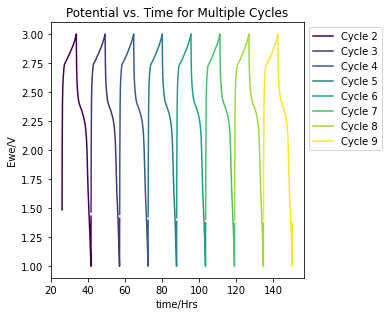

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Specify the path to your file
file_path = '/home/mugisa/Documents/battery_app/data/MnO2_coin cell_cycling_C02.txt'

# Define the column names based on the given headers
columns = ["cycle number","Q discharge/mA.h","Q charge/mA.h","Ewe/V","(Q-Qo)/mA.h", "time/s", "<I>/mA","Capacity/mA.h","Efficiency/%"]

# Read the data, specifying the delimiter as a tab
data = pd.read_csv(file_path, sep='\t', skiprows=1, header=None, names=columns, engine='python')

# Convert the comma to a dot if the numbers are in the European format
data = data.applymap(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

# List of cycle numbers to plot
cycles_to_plot = [2,3,4,5,6,7,8,9]

# Define a colormap to get different colors for each cycle
colors = plt.cm.viridis(np.linspace(0, 1, len(cycles_to_plot)))

fig, ax = plt.subplots(figsize=(5.5, 4.5))

for index, cycle_number in enumerate(cycles_to_plot):
    # Filter the data for the given cycle number
    cycle_data = data[data['cycle number'] == cycle_number]

    time = cycle_data['time/s'].to_numpy()/3600
    Ewe_V = cycle_data['Ewe/V'].to_numpy()

    # Plot Ewe/V vs time, using the colors from the colormap
    ax.plot(time, Ewe_V, color=colors[index], label=f'Cycle {cycle_number}')

ax.set_xlabel('time/Hrs')
ax.set_ylabel('Ewe/V')
ax.set_title('Potential vs. Time for Multiple Cycles')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize=10)  # Move the legend outside
ax.grid(False)
plt.tight_layout()
plt.show()
# fig.savefig("C:/Users/John/Desktop/cycling/v_t.png", format="png", dpi=1000, bbox_inches='tight')

NameError: name 'Q_charge' is not defined

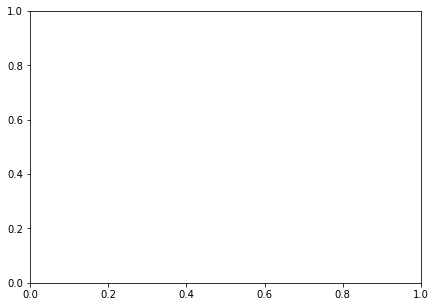

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cmath

# Specify the path to your file
file_path = '/home/mugisa/Documents/battery_app/data/MnO2_coin cell_cycling_C02.txt'

# Define the column names based on the given headers
columns = ["cycle number","Q discharge/mA.h","Q charge/mA.h","Ewe/V","(Q-Qo)/mA.h", "time/s", "<I>/mA"]

# Read the data, specifying the delimiter as a tab
data = pd.read_csv(file_path, sep='\t', skiprows=1, header=None, names=columns, engine='python')

# Convert the comma to a dot if the numbers are in the European format
data = data.applymap(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)
# print(data)
# List of cycle numbers to plot
cycles_to_plot = [1,2,3,4,5,6,7,8,9,10]

# Define a colormap to get different colors for each cycle
colors = plt.cm.viridis(np.linspace(0, 1, len(cycles_to_plot)))

fig, ax = plt.subplots(figsize=(7, 5))

for index, cycle_number in enumerate(cycles_to_plot):
    # Filter the data for the given cycle number
    cycle_data = data[data['cycle number'] == cycle_number]

    Q_discharge = cycle_data['Q discharge/mA.h'].to_numpy()[500:-5]
    Ewe_V1 = cycle_data['Ewe/V'].to_numpy()[500:-5]


    # Plot charge and discharge data, using the colors from the colormap
    ax.plot(Q_charge, Ewe_V, color=colors[index], label=f'Charge for Cycle {cycle_number}')
    ax.plot(Q_discharge, Ewe_V1, color=colors[index], linestyle='dashed', label=f'Cycle {cycle_number}')

ax.set_xlabel('Q (mA.h)')
ax.set_ylabel('Ewe/V')
ax.set_title('Discharge for Multiple Cycles')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()